# Building models for named entity recognition

The project consists in building two named entity recognition (NER) systems. The systems will make use of the IOB tagging scheme to detect entities of type PER, ORG, LOC and MISC. The tagging scheme thus includes the following tags, assuming one tag per token:

- B-PER and I-PER: token corresponds to the start, resp. the inside, of a person's entity
- B-LOC and I-LOC: token corresponds to the start, resp. the inside, of a location entity
- B-ORG and I-ORG: token corresponds to the start, resp. the inside, of an organization entity
- B-MISC and I-MISC: token corresponds to the start, resp. the inside, of any other named entity
- O: token corresponds to no entity

## Dataset

You are provided with training, validation and test data derived from the CONLL 03 dataset. The dataset has been marginally cleaned and reformatted for facilitated use. You can directly load the three folds from the json file provided:

```python
with open('conll03-iob-pos.json', 'r') as f:
    data = json.load(f)
```
For each fold, the dataset consists of a list of dictionaries, one per sample, with the two fields 'tokens' and 'labels', e.g.

{'tokens': ['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.'], 'tags': ['B-ORG', 'O', 'B-MISC', 'O', 'O', 'O', 'B-MISC', 'O', 'O']}

## TODO

Building on the notebooks we've seen during the lectures and on the tipcs below, you task is to build two tagging models:
1. a RNN-based model: an embedding layer, a LSTM layer, a feed-forward layer
2. a fine-tuned BERT tagger: a BERT (pre-trained) layer, a feed-forward layer
The final feed-forward layer procudes a probability distribution over the set possible tags for each input token.

For both, we will use BERT's tokenizer, which is a sub-word tokenizer. The advantage of this tokenizer is that the vocabulary is finite (no out-of-vocabulary tokens): you can get the vocabulary size from tokenizer.vocab_size and you don't have to bother with defining your vocabulary and mapping unkown tokens to some special token. The disadvantage of sub-word tokenization is that we will have to relabel the input sequences, which are labeled on a word basis rather than on a sub-word basis. To make things easier, we provide a function that aligns and encode the labels. Note that special tokens will arbitrarily get the tag -100 which is a default value to indicate Torch's loss functions that gradient should not be propagated from there (in other words, ignore thos tokens in training).

Another advantage of using the same tokenizer is that you will have to prepare your dataset and the corresponding loaders only once for the two models.

Here are the steps you'll have to go through:

1. Define a Dataset class that will hold for each sample the list of encoded tokens and the corresponding list of encoded tags. You will then encode the three folds as a Dataset and define the corresponding DataLoader instances.

2. Define your LSTM model class and train it. You can get inspired by the RNN language model notebook.

3. Define your BERT model class and train it. You can adapt the LLM finetuning notebook, changing the classification head to operate on each token (as for the LSTM) rather than on the embedding of the [CLS] token.

4. Evaluate both and compare. Token tag accuracy is one measure (used for instance to measure the convergence of training) but it's not the ultimate one as the final task is not to tag tokens but to detect entities. You should thus also report in the final evaluation the entitu recognition rate.

One last thing to think about: computation of the accuracy for validation and testing must be adapted in two ways compared to what we've seen in the previous notebooks. First, each prediction is a sequence of tags and not a single tag. Second, tags corresponding to the special tokens (indicated as -100 in the reference) must not be accounted for when computing the accuracy (maybe pytorch does that for you but you have to make sure it does).

**Good luck no your mission!**

## REPORT

The report will be a commented notebook. This is not a python programing project but a NLP project. I'm thus expecting you to comment on your model definition choices, to analyze the results and errors, to provide hints at how things could be improved. If you did trial and error cells, please clean up a bit to facilitate reading, leaving only the final version in the report notebook.



In [25]:
import json
import gzip

from transformers import AutoModel, AutoTokenizer

from sklearn.metrics import accuracy_score

import torch
from torch.utils.data import Dataset, DataLoader


In [26]:
!pip install seqeval

## Tag set (IOB) for Named Entity Recognition

Before training any model, we need a clear definition of **what we want to predict**.

In this project we perform **Named Entity Recognition (NER)** using the standard **IOB tagging scheme**, which represents entities directly in the token sequence:
- `O` marks tokens that are not part of a named entity,
- `B-...` marks the first token of an entity span,
- `I-...` marks the continuation of the same entity span.

We focus on four entity types: **PER**, **ORG**, **LOC**, and **MISC**, leading to a compact set of labels used consistently throughout the notebook.  
To train neural models, these labels are mapped to numeric identifiers (and back), so that predictions can be learned and later interpreted in human-readable form.


In [27]:
tag2id = {
    'O': 0,
    'B-LOC': 1, 'I-LOC': 2,
    'B-ORG': 3, 'I-ORG': 4,
    'B-PER': 5, 'I-PER': 6,
    'B-MISC': 7, 'I-MISC': 8
}

id2tag = {v:k for k,v in tag2id.items()}

print(id2tag)

{0: 'O', 1: 'B-LOC', 2: 'I-LOC', 3: 'B-ORG', 4: 'I-ORG', 5: 'B-PER', 6: 'I-PER', 7: 'B-MISC', 8: 'I-MISC'}


## Dataset overview and splits

We load the annotated NER dataset provided for the project and inspect its structure before modeling.

The dataset is split into three parts:
- **train**: used to learn model parameters,
- **validation**: used to monitor performance during development and make modeling choices,
- **test**: kept untouched until the end to report the final results.

Each sentence is represented as a sequence of tokens, paired with a sequence of IOB tags (one label per token).  
Printing the split sizes and a sample entry is a quick way to confirm that the data is correctly loaded and that the format matches what the models will consume.


In [28]:
with gzip.open('conll03-iob-pos.json.gz', 'r') as f:
    data = json.load(f)

for fold in ('train', 'valid', 'test'):
    print(fold, len(data[fold]))

print(data['train'][0])

train 14041
valid 3250
test 3453
{'tokens': ['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.'], 'tags': ['B-ORG', 'O', 'B-MISC', 'O', 'O', 'O', 'B-MISC', 'O', 'O']}


## Choosing the tokenizer (DistilBERT)

To work with Transformer-based models, we must adopt the same input representation used during pre-training.  
For this reason, we initialize the tokenizer associated with the selected checkpoint (**DistilBERT, cased**).

Conceptually, the tokenizer defines how raw text is turned into the model’s “native” format:
- it breaks each sentence into the units the model was trained on (often smaller than words),
- it assigns a unique integer ID to each unit,
- it applies a consistent handling of sentence boundaries and padding.

Using the same tokenizer for the whole notebook ensures that the dataset, the BERT tagger, and the evaluation pipeline all operate on a compatible representation.


In [29]:
checkpoint = 'distilbert-base-cased'
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
print(tokenizer)

DistilBertTokenizerFast(name_or_path='distilbert-base-cased', vocab_size=28996, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)


## From word tokens to model inputs (tokenization and alignment)

The dataset provides sentences as **word-level tokens**, with one IOB label per word.  
However, Transformer models such as DistilBERT operate on a different granularity: they may split a word into multiple **subword tokens**.

In this step we apply the tokenizer to a few training sentences to observe:
- how word tokens are transformed into the token sequence consumed by the model,
- where special tokens and padding appear,
- and, most importantly, how each produced token can be traced back to its originating word.

This inspection is essential because NER supervision is defined at the **word level**, while the model predicts at the **token level**.  
The alignment information returned by the tokenizer will be used in the next step to project the gold IOB labels onto the tokenized representation in a consistent way.


In [30]:
train_texts = [x['tokens'] for x in data['train']]
train_labels = [x['tags'] for x in data['train']]

inputs = tokenizer(train_texts, is_split_into_words=True, padding=True, truncation=True, return_tensors="pt")

print(train_texts[0])
print(tokenizer.convert_ids_to_tokens(inputs['input_ids'][0]))
print(inputs.word_ids(batch_index=0))

['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.']
['[CLS]', 'EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'la', '##mb', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[P

## Aligning supervision to the model’s tokenization

The dataset provides one NER label per **word**, while DistilBERT processes text as a sequence of **subword tokens**.  
This creates a mismatch: the model predicts a tag for every produced token, but the gold supervision is available only at the word level.

To resolve this, we introduce a simple alignment procedure:
- tokens that do not correspond to real input words (special tokens and padding) are **ignored** during training and evaluation;
- when a single word is split into multiple subwords, we propagate the word label across its subwords so that entity spans remain consistent.

The goal is not to “change” the annotation, but to **project it onto the tokenized representation** used by the model.  
A short print-based inspection on a sample sentence is included to verify that the alignment behaves as intended before training.


In [31]:
def align_and_encode_labels(_token_ids, _word_ids, _labels):
    '''
    Align word-level labels to sub-word tokens for an entry
    '''

    global tag2id

    ignore_id = -100

    buf = [ignore_id] # ignore tag for token [CLS]

    prev_token_word = -1
    which_type = 0

    # print(len(_token_ids), tokenizer.convert_ids_to_tokens(_token_ids))
    # print(_word_ids)
    # print(_labels)

    for i in range(1, len(_token_ids)):
        word_id = _word_ids[i]

        if word_id == None:
            # token does not belong to any input word ([CLS], [SEP] or [PAD]) -- ignore
            buf.append(ignore_id)

        else:
            tag_id = tag2id[_labels[word_id]]

            if word_id == prev_token_word:
            # sub-word token of the previous word: need to do something
            #   word has an O tag: just use a O tag
            #   word has an I-X tag: just use the I-X tag
            #   word has a B-X tag: replace by corresponding I-X tag

                buf.append(tag_id + 1 if tag_id in (1, 3, 5, 7) else tag_id)

            else:
                # token starting a new word --> keep tag unchanged
                prev_token_word = word_id
                buf.append(tag_id)

    return buf

#
# The following illustrate how we can get aligned and encoded labels for sample i in the training set.
#

i = 10

print(train_texts[i], train_labels[i])

new_labels = align_and_encode_labels(inputs['input_ids'][i], inputs.word_ids(batch_index=i), train_labels[i])

tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][i])

for j in range(len(tokens)):
    if tokens[j] != '[PAD]':
        print(tokens[j], ' -- ', id2tag[new_labels[j]] if new_labels[j] >= 0 else 'NONE')

['Spanish', 'Farm', 'Minister', 'Loyola', 'de', 'Palacio', 'had', 'earlier', 'accused', 'Fischler', 'at', 'an', 'EU', 'farm', 'ministers', "'", 'meeting', 'of', 'causing', 'unjustified', 'alarm', 'through', '"', 'dangerous', 'generalisation', '.', '"'] ['B-MISC', 'O', 'O', 'B-PER', 'I-PER', 'I-PER', 'O', 'O', 'O', 'B-PER', 'O', 'O', 'B-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
[CLS]  --  NONE
Spanish  --  B-MISC
Farm  --  O
Minister  --  O
Loyola  --  B-PER
de  --  I-PER
Pa  --  I-PER
##la  --  I-PER
##cio  --  I-PER
had  --  O
earlier  --  O
accused  --  O
Fi  --  B-PER
##sch  --  I-PER
##ler  --  I-PER
at  --  O
an  --  O
EU  --  B-ORG
farm  --  O
ministers  --  O
'  --  O
meeting  --  O
of  --  O
causing  --  O
un  --  O
##ju  --  O
##st  --  O
##ified  --  O
alarm  --  O
through  --  O
"  --  O
dangerous  --  O
general  --  O
##isation  --  O
.  --  O
"  --  O
[SEP]  --  NONE


## Shared preprocessing for a fair comparison

To compare the two NER systems fairly, we keep the preprocessing pipeline consistent across models.

In particular, both the BiLSTM baseline and the BERT tagger operate on the same tokenized representation, and the gold IOB labels are projected onto that representation. Tokens that do not correspond to real words (e.g., special markers and padding) are excluded from training and evaluation.

This ensures that differences in performance can be attributed to the modeling choices (BiLSTM vs BERT), rather than to different input processing.


# **From the starter code to two complete NER systems**

Starting from the baseline provided by the professor (data loading, tag set definition, tokenization, and label alignment), we build two full sequence tagging models:

1. **BiLSTM tagger** as an RNN-based baseline (Embedding + BiLSTM + Linear classifier).
2. **Fine-tuned BERT tagger** (pre-trained encoder + token-level classification head).

Both systems are trained with a token-level cross-entropy objective while ignoring non-evaluable positions, and they are evaluated using standard NER metrics in later sections.



## Packaging the data for training (custom PyTorch Dataset)

To train our taggers efficiently, we wrap the NER data into a custom PyTorch Dataset.

Conceptually, this component acts as the bridge between the annotated corpus and the neural models:
- it turns each sentence into the model’s input representation (token IDs and masks),
- it projects the gold IOB annotations onto that same representation,
- and it produces a consistent, ready-to-batch output format.

By centralizing tokenization and label alignment inside the dataset class, we ensure that every training, validation, and test example is processed in the same way, which simplifies the training loops and reduces the risk of subtle inconsistencies.


In [32]:
# ===============================
# Dataset class for NER task
# ===============================

class NERDataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        """
        texts: list of lists of word-level tokens
        labels: list of lists of word-level IOB tags
        tokenizer: BERT tokenizer
        max_length: maximum sequence length (for padding/truncation)
        """
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

        # Tokenizing all sequences at initialization
        self.encodings = tokenizer(
            texts,
            is_split_into_words=True,
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors='pt'
        )

        # Aligning word-level labels to subword tokens
        self.encoded_labels = []
        for i in range(len(texts)):
            label_ids = align_and_encode_labels(
                self.encodings['input_ids'][i],
                self.encodings.word_ids(batch_index=i),
                labels[i]
            )
            # Pad or truncate to max_length
            if len(label_ids) < self.max_length:
                label_ids += [-100]*(self.max_length - len(label_ids))
            else:
                label_ids = label_ids[:self.max_length]
            self.encoded_labels.append(label_ids)

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        # Returning a dictionary compatible with PyTorch
        item = {key: self.encodings[key][idx] for key in self.encodings}
        item['labels'] = torch.tensor(self.encoded_labels[idx])
        return item


## Reproducibility (setting random seeds)

Neural network training involves several sources of randomness (e.g., parameter initialization, shuffling of mini-batches, and certain GPU kernels).  
As a result, re-running the same notebook can lead to slightly different numbers, even when the overall trend and conclusions remain unchanged.

To make experiments **repeatable** and ensure that reported results match the displayed outputs, we fix the random seeds and (when possible) enforce deterministic behavior. This improves the reliability of comparisons between the BiLSTM baseline and the fine-tuned BERT model.


In [33]:
# ===============================
# Reproducibility (seeds + deterministic behavior)
# ===============================

import os, random
import numpy as np
import torch

SEED = 123

random.seed(SEED)
np.random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)

torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# Making CuDNN deterministic
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


## Preparing data for training and evaluation

At this stage we turn the raw dataset splits into objects that can be consumed efficiently by PyTorch training loops.

Each split (train/validation/test) is wrapped into the same `NERDataset` pipeline, so that:
- inputs are represented in a consistent way,
- supervision is aligned to the tokenized representation,
- and all splits are processed identically (the only difference is how they are used).

We then create `DataLoaders` to iterate over the data in mini-batches:
- the **training** loader shuffles examples to improve learning dynamics,
- **validation** and **test** loaders keep a fixed order to ensure stable and reproducible evaluation.


In [34]:
# ===============================
# Create Datasets and DataLoaders
# ===============================

# Preparing the datasets
train_dataset = NERDataset(
    texts=[x['tokens'] for x in data['train']],
    labels=[x['tags'] for x in data['train']],
    tokenizer=tokenizer,
    max_length=128
)

valid_dataset = NERDataset(
    texts=[x['tokens'] for x in data['valid']],
    labels=[x['tags'] for x in data['valid']],
    tokenizer=tokenizer,
    max_length=128
)

test_dataset = NERDataset(
    texts=[x['tokens'] for x in data['test']],
    labels=[x['tags'] for x in data['test']],
    tokenizer=tokenizer,
    max_length=128
)

# Creating the DataLoaders
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=16, num_workers=0, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=16, num_workers=0, pin_memory=True)

print("Datasets and DataLoaders ready!")
print(f"Train batches: {len(train_loader)}, Valid batches: {len(valid_loader)}, Test batches: {len(test_loader)}")


Datasets and DataLoaders ready!
Train batches: 878, Valid batches: 204, Test batches: 216


## Sanity check: tokenization, padding, and label alignment

Before training, we run a quick consistency check on one sample to ensure that:
- all tensors (`input_ids`, `attention_mask`, `labels`) have length `max_length`;
- special tokens (e.g., `[CLS]`, `[SEP]`) and padding positions are assigned label `-100` (ignored by the loss);
- word-level labels are correctly aligned to the first subword token of each word (depending on the alignment strategy).

This helps catch the most common source of NER bugs: mismatched lengths or incorrect label alignment after subword tokenization.


In [35]:
# ===============================
# Sanity check: tokenization + label alignment
# ===============================

# Picking which dataset to inspect
ds = train_dataset
idx = 0

sample = ds[idx]

# Basic shapes
print("Shapes:")
for k, v in sample.items():
    print(f"  {k}: {tuple(v.shape)}")

seq_len = sample["input_ids"].shape[0]
assert sample["attention_mask"].shape[0] == seq_len
assert sample["labels"].shape[0] == seq_len
print(f"\n Consistent sequence length: {seq_len}")

# Checking that attention_mask=0 implies labels=-100
pad_pos = (sample["attention_mask"] == 0).nonzero(as_tuple=True)[0]
if len(pad_pos) > 0:
    ok = (sample["labels"][pad_pos] == -100).all().item()
    print(f"Padding positions ignored in labels: {ok}")
else:
    print("No padding positions in this sample.")

# Helper: robust id->tag (works whether id2tag is dict or list)
def id_to_tag(i):
    if i == -100:
        return "IGN"
    if isinstance(id2tag, dict):
        return id2tag.get(i, f"UNK({i})")
    # assuming list-like
    return id2tag[i] if 0 <= i < len(id2tag) else f"UNK({i})"

tokens = tokenizer.convert_ids_to_tokens(sample["input_ids"].tolist())

word_ids = None
try:
    word_ids = ds.encodings.word_ids(batch_index=idx)
except Exception:
    pass

print("\nToken-level view (stops at first padding):")
header = "idx  token           label_id  label"
if word_ids is not None:
    header = "idx  token           word_id  label_id  label"
print(header)
print("-" * len(header))

for i in range(seq_len):
    if sample["attention_mask"][i].item() == 0:
        break
    tok = tokens[i]
    lid = sample["labels"][i].item()
    lab = id_to_tag(lid)
    if word_ids is not None:
        wid = word_ids[i]
        print(f"{i:02d}  {tok:14s}  {str(wid):6s}  {lid:7d}  {lab}")
    else:
        print(f"{i:02d}  {tok:14s}  {lid:7d}  {lab}")

Shapes:
  input_ids: (128,)
  attention_mask: (128,)
  labels: (128,)

 Consistent sequence length: 128
Padding positions ignored in labels: True

Token-level view (stops at first padding):
idx  token           word_id  label_id  label
---------------------------------------------
00  [CLS]           None       -100  IGN
01  EU              0             3  B-ORG
02  rejects         1             0  O
03  German          2             7  B-MISC
04  call            3             0  O
05  to              4             0  O
06  boycott         5             0  O
07  British         6             7  B-MISC
08  la              7             0  O
09  ##mb            7             0  O
10  .               8             0  O
11  [SEP]           None       -100  IGN

CLS token check: token=[CLS] label=IGN
SEP token check: idx=11 token=[SEP] label=IGN


## Sanity check outcome

A quick inspection confirms that the preprocessing pipeline is consistent:
- inputs, masks, and labels have the expected fixed length (`max_length = 128`);
- padding positions are correctly excluded from training/evaluation (`labels = -100` where `attention_mask = 0`);
- special tokens (`[CLS]`, `[SEP]`) are ignored (`-100`);
- word-to-subword alignment behaves as expected (subword pieces share the same `word_id`).

This check reduces the risk of silent bugs in NER training, where label misalignment can lead to misleading metrics.


## **BiLSTM tagger (RNN baseline)**

As a first NER system, we implement a classic sequence-tagging baseline based on recurrent neural networks.

The model follows a simple and widely used design:
- an **embedding layer** turns discrete token IDs into dense vectors;
- a **bidirectional LSTM** encodes each token in context, combining information from both left and right surrounding tokens;
- a **linear layer** produces a tag prediction for every token position.

This baseline is intentionally lightweight and provides a meaningful reference point for comparison with the Transformer-based model introduced later.

### Handling padding (attention masks + packed sequences)

Unlike Transformers, an RNN processes tokens sequentially. If we feed padded sequences directly, the LSTM will also “read” padding positions, which can slightly contaminate hidden states.

To keep the baseline methodologically clean, we use the `attention_mask` to compute true sequence lengths and run the BiLSTM on packed sequences (`pack_padded_sequence`). This prevents padding tokens from affecting the recurrent dynamics, while preserving fixed-size tensors for batching and loss computation.


In [36]:
# ===============================
# BiLSTM model for NER
# ===============================

import torch
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class LSTMTagger(nn.Module):
    def __init__(self, vocsize, nclasses, embed_dim=200, hidden_dim=200, dropout=None, padding_idx=0):
        super().__init__()
        self.embedding = nn.Embedding(vocsize, embed_dim, padding_idx=padding_idx)
        self.bilstm = nn.LSTM(
            input_size=embed_dim,
            hidden_size=hidden_dim,
            num_layers=1,
            batch_first=True,
            bidirectional=True
        )
        self.dropout = nn.Dropout(dropout) if dropout is not None else None
        self.linear = nn.Linear(hidden_dim * 2, nclasses)

    def forward(self, **kwargs):
        # Support both conventions
        ids = kwargs.get("ids", None)
        if ids is None:
            ids = kwargs.get("input_ids", None)
        if ids is None:
            raise ValueError("Expected input under key 'ids' or 'input_ids'.")

        attention_mask = kwargs.get("attention_mask", None)  # [B, T] or None

        x = self.embedding(ids)  # [B, T, E]
        if self.dropout is not None:
            x = self.dropout(x)

        # If we have a mask, pack the sequence to avoid processing PAD steps
        if attention_mask is not None:
            lengths = attention_mask.sum(dim=1).to(torch.long)  # [B]
            # safety: avoid zero-length (shouldn't happen, but just in case)
            lengths = torch.clamp(lengths, min=1)

            packed = pack_padded_sequence(
                x,
                lengths.cpu(),
                batch_first=True,
                enforce_sorted=False
            )
            packed_out, _ = self.bilstm(packed)
            x, _ = pad_packed_sequence(
                packed_out,
                batch_first=True,
                total_length=ids.size(1)  # keep [B, T, 2H]
            )
        else:
            x, _ = self.bilstm(x)  # [B, T, 2H]

        if self.dropout is not None:
            x = self.dropout(x)

        logits = self.linear(x)         # [B, T, C]
        return logits.permute(0, 2, 1)  # [B, C, T]


## Training the BiLSTM baseline

We train the BiLSTM tagger on the training split and monitor performance on the validation split.

The objective is straightforward: learn to assign an IOB tag to each token position while ignoring tokens that are not part of the actual sentence content (e.g. padding and special markers).  
To keep training stable with recurrent networks, we apply gradient clipping.

During training we track:
- the **training loss** to verify that optimization is progressing,
- a **validation token-level accuracy** as a lightweight diagnostic metric (entity-level evaluation will be reported later with `seqeval`).


Epoch 1/3, Training loss: 0.4663
Validation token-level accuracy: 0.9099



Epoch 2/3, Training loss: 0.1693
Validation token-level accuracy: 0.9317



Epoch 3/3, Training loss: 0.0761
Validation token-level accuracy: 0.9405



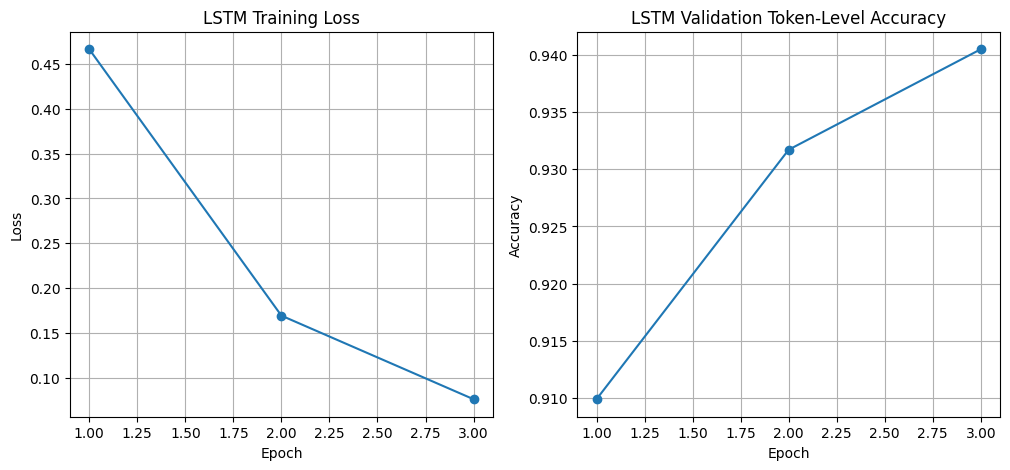

In [37]:
# ===============================
# Training loop for LSTMTagger
# ===============================

from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.nn.utils import clip_grad_norm_
import torch.nn as nn
import torch

# Hyperparameters
embedding_dim = 128
hidden_dim = 256
num_labels = len(tag2id)
num_epochs = 3
lr = 1e-3
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Instantiating the model
model = LSTMTagger(
    vocsize=tokenizer.vocab_size,
    nclasses=num_labels,
    embed_dim=embedding_dim,
    hidden_dim=hidden_dim,
    dropout=None,
    padding_idx=tokenizer.pad_token_id
).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=-100)
optimizer = optim.Adam(model.parameters(), lr=lr)

train_losses_lstm = []
val_accuracies_lstm = []

for epoch in range(1, num_epochs + 1):
    model.train()
    total_loss = 0.0

    loop = tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs}", leave=False)
    for batch in loop:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)  # [batch, seq_len]

        optimizer.zero_grad(set_to_none=True)

        logits = model(ids=input_ids, attention_mask=attention_mask)

        # With logits [B, C, T] and labels [B, T], we can compute CE directly
        loss = criterion(logits, labels)

        loss.backward()
        clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        total_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    avg_loss = total_loss / len(train_loader)
    train_losses_lstm.append(avg_loss)
    print(f"Epoch {epoch}/{num_epochs}, Training loss: {avg_loss:.4f}")

    # Validation token-level accuracy (on non-ignored positions)
    model.eval()
    correct, total = 0, 0

    with torch.no_grad():
        for batch in valid_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)  # [batch, seq_len]

            logits = model(ids=input_ids, attention_mask=attention_mask)
            predictions = torch.argmax(logits, dim=1)  # -> [batch, seq_len]

            mask = labels != -100
            correct += (predictions[mask] == labels[mask]).sum().item()
            total += mask.sum().item()

    val_acc = correct / total
    val_accuracies_lstm.append(val_acc)
    print(f"Validation token-level accuracy: {val_acc:.4f}\n")

# ===============================
# Plot Training Loss and Validation Accuracy
# ===============================
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses_lstm, marker='o')
plt.title("LSTM Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), val_accuracies_lstm, marker='o')
plt.title("LSTM Validation Token-Level Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)

plt.show()


## Training dynamics (BiLSTM baseline)

The BiLSTM baseline shows stable learning behavior across the 3 epochs:
- the **training loss decreases substantially** (roughly from ~0.47 to ~0.08), indicating smooth optimization;
- the **validation token-level accuracy increases** (from ~0.91 to ~0.94), with the largest improvement occurring early and smaller gains later, suggesting the model is approaching a plateau.

Overall, the curves reflect a well-behaved training process (no divergence or instability).


## Test set evaluation (BiLSTM)

After training, we evaluate the BiLSTM baseline on the held-out test set.

Because NER is a structured sequence task, we report results using **entity-level metrics** (Precision / Recall / F1) computed with `seqeval`, which is the standard evaluation under the IOB tagging scheme.  
To obtain a fair score, we exclude all non-evaluable positions (padding and special tokens) and compare predictions and gold labels only on valid tokens.

For completeness, we also compute **token-level accuracy** on the same positions. This is a lightweight diagnostic metric, but it can be less informative than entity-level F1 for NER.


In [38]:
# ===============================
# Final Evaluation on Test Set
# ===============================

from tqdm import tqdm
from seqeval.metrics import classification_report

model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Evaluating on test set"):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)  # [B, T]
        logits = model(ids=input_ids, attention_mask=attention_mask)  # [B, C, T]

        # Predicted class per token: [B, T]
        predictions = torch.argmax(logits, dim=1)

        # Processing each sequence in the batch
        for i in range(labels.size(0)):
            pred_seq = []
            label_seq = []

            for pred_id, label_id in zip(predictions[i], labels[i]):
                if label_id.item() != -100:  # ignore special tokens / padding / ignored positions
                    pred_seq.append(id2tag[pred_id.item()])
                    label_seq.append(id2tag[label_id.item()])

            all_preds.append(pred_seq)
            all_labels.append(label_seq)

# ===============================
# Entity-level evaluation
# ===============================
print("Entity-level evaluation (seqeval):\n")
print(classification_report(all_labels, all_preds))

# ===============================
# Token-level accuracy (for completeness)
# ===============================
correct, total = 0, 0
for preds, golds in zip(all_preds, all_labels):
    for p, g in zip(preds, golds):
        correct += int(p == g)
        total += 1

token_acc = correct / total if total > 0 else 0.0
print(f"Token-level accuracy on test set: {token_acc:.4f}")

Evaluating on test set: 100%|██████████| 216/216 [00:10<00:00, 19.65it/s]


Entity-level evaluation (seqeval):

              precision    recall  f1-score   support

         LOC       0.76      0.75      0.75      1666
        MISC       0.48      0.57      0.52       702
         ORG       0.50      0.57      0.53      1661
         PER       0.54      0.63      0.58      1615

   micro avg       0.58      0.64      0.61      5644
   macro avg       0.57      0.63      0.60      5644
weighted avg       0.58      0.64      0.61      5644

Token-level accuracy on test set: 0.9175


## Test set results (BiLSTM baseline)

**Overall performance**
- The model achieves a **micro-averaged F1-score of ~0.61** (Precision ~0.58, Recall ~0.64) over 5,644 named entities.
- The **token-level accuracy is ~0.92** (exactly 0.9175). This value is expected to be significantly higher than entity-level F1 in NER because:
  - The vast majority of tokens are correctly identified as `O` (non-entity), inflating the accuracy.
  - Entity-level scoring follows strict constraints: a single mistake in either boundary detection or type classification invalidates the entire span.

**Per-entity breakdown**
- **LOC** remains the strongest category (**F1 ~ 0.75**), as locations typically exhibit more predictable surface patterns and contextual markers.
- **PER** shows moderate performance (**F1 ~ 0.58**), while **ORG** proves more challenging (**F1 ~ 0.53**), likely due to frequent structural ambiguities and overlap with other categories.
- **MISC** is confirmed as the most difficult class (**F1 ~ 0.52**), which is expected given the high variety and less consistent lexical cues of the entities included in this group.

Overall, these results establish a solid baseline for the RNN architecture. In the next section, we transition to a Transformer-based model (BERT), which is expected to provide superior contextual representations and improve the detection of complex entity boundaries.

## **BERT tagger (Transformer-based NER model)**

We now implement the second NER system based on a pre-trained Transformer.

The core idea is to reuse a powerful language representation learned during large-scale pre-training and adapt it to NER:
- the Transformer encoder provides contextual representations for each token in the sentence,
- a small classification head maps those representations to the IOB tag set.

Compared to the BiLSTM baseline, this model typically captures richer context and long-range dependencies, which often translates into stronger entity-level performance, especially for ambiguous categories such as ORG and the heterogeneous MISC class.


In [39]:
# ===============================
# BERT-based Tagger for NER
# ===============================

import torch
import torch.nn as nn
from transformers import AutoModel

class BERTTagger(nn.Module):
    def __init__(self, checkpoint, num_labels, dropout=0.1):
        super().__init__()

        self.encoder = AutoModel.from_pretrained(checkpoint)

        hidden_size = getattr(self.encoder.config, "hidden_size", None)
        if hidden_size is None:
            hidden_size = getattr(self.encoder.config, "dim")  # e.g. DistilBERT

        self.dropout = nn.Dropout(dropout) if dropout is not None else None
        self.classifier = nn.Linear(hidden_size, num_labels)

    def forward(self, **kwargs):
        """
        Expects a HuggingFace-style batch dict, e.g.:
          - input_ids: [batch, seq_len]
          - attention_mask: [batch, seq_len]
        Returns:
          - logits: [batch, num_labels, seq_len]
        """
        outputs = self.encoder(**kwargs)
        x = outputs.last_hidden_state  # [batch, seq_len, hidden]

        if self.dropout is not None:
            x = self.dropout(x)

        logits = self.classifier(x)    # [batch, seq_len, num_labels]
        return logits.permute(0, 2, 1) # -> [batch, num_labels, seq_len]


## Fine-tuning BERT for NER

We fine-tune the pre-trained Transformer on the NER task by updating its parameters end-to-end on the training split.

Fine-tuning follows the standard recipe:
- we keep the model close to its pre-trained knowledge by using a **small learning rate**,
- we train a token-level classifier on top of contextual representations produced by the encoder,
- and we ignore non-evaluable positions (special tokens and padding) so the objective reflects only real sentence tokens.

During training we track:
- **training loss**, to verify that optimization progresses smoothly,
- **validation token-level accuracy**, as a quick diagnostic signal while training.


Epoch 1/3, Training loss: 0.1940
Validation token-level accuracy: 0.9736



Epoch 2/3, Training loss: 0.0624
Validation token-level accuracy: 0.9804



Epoch 3/3, Training loss: 0.0363
Validation token-level accuracy: 0.9814



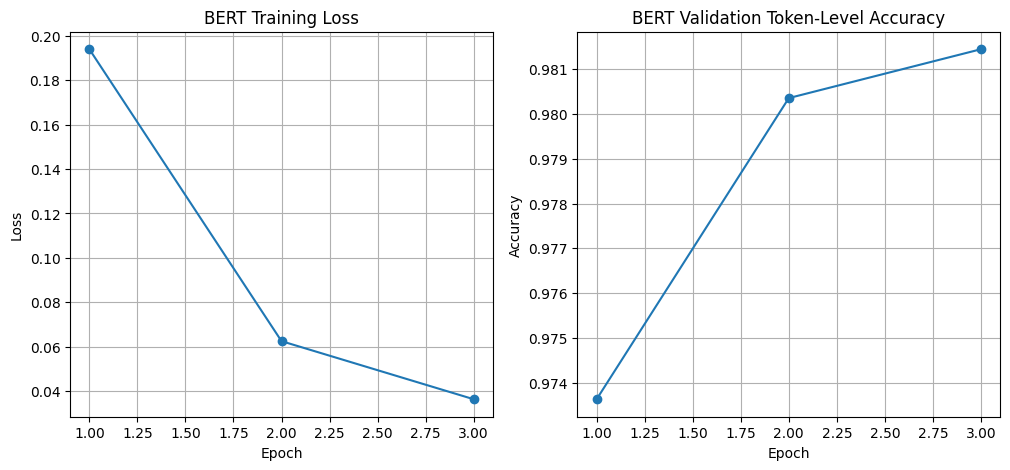

In [40]:
# ===============================
# Training loop for BERTTagger
# ===============================

from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn as nn
import torch

# Hyperparameters
num_labels = len(tag2id)
num_epochs = 3
lr = 2e-5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Instantiating the model
bert_model = BERTTagger(
    checkpoint=checkpoint,
    num_labels=num_labels
).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=-100)
optimizer = optim.AdamW(bert_model.parameters(), lr=lr)

train_losses_bert = []
val_accuracies_bert = []

for epoch in range(1, num_epochs + 1):
    bert_model.train()
    total_loss = 0.0

    loop = tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs}", leave=False)
    for batch in loop:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)  # [B, T]

        optimizer.zero_grad(set_to_none=True)

        logits = bert_model(input_ids=input_ids, attention_mask=attention_mask)

        # CE directly on [B, C, T] vs [B, T]
        loss = criterion(logits, labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    avg_loss = total_loss / len(train_loader)
    train_losses_bert.append(avg_loss)
    print(f"Epoch {epoch}/{num_epochs}, Training loss: {avg_loss:.4f}")

    # Validation token-level accuracy
    bert_model.eval()
    correct, total = 0, 0

    with torch.no_grad():
        for batch in valid_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            logits = bert_model(input_ids=input_ids, attention_mask=attention_mask)  # [B, C, T]
            predictions = torch.argmax(logits, dim=1)  # -> [B, T]

            mask = labels != -100
            correct += (predictions[mask] == labels[mask]).sum().item()
            total += mask.sum().item()

    val_acc = correct / total
    val_accuracies_bert.append(val_acc)
    print(f"Validation token-level accuracy: {val_acc:.4f}\n")

# ===============================
# Plot Training Loss and Validation Accuracy
# ===============================
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses_bert, marker='o')
plt.title("BERT Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), val_accuracies_bert, marker='o')
plt.title("BERT Validation Token-Level Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)

plt.show()


## Training dynamics (fine-tuned BERT)

The fine-tuned BERT tagger converges quickly and remains stable over 3 epochs.

- **Training loss** decreases sharply (from **around 0.2** to **around 0.04**), indicating effective fine-tuning of the pre-trained encoder.
- **Validation token-level accuracy** improves steadily across epochs (from **about 0.97** to **about 0.98**), with **smaller gains after the first epoch** as the curve starts to plateau near convergence.

Overall, the curves reflect a typical fine-tuning trajectory:
- fast early gains driven by pre-trained representations,
- diminishing returns in later epochs as the model approaches convergence.

As with the BiLSTM baseline, token-level accuracy is mainly a diagnostic signal (especially in NER, where entity-level metrics are more informative).


## Test set evaluation (fine-tuned BERT)

We evaluate the fine-tuned BERT tagger on the held-out test set.

The main NER metric is computed at the **entity level** using `seqeval` as we did with the BiLSMT model.  
To ensure a fair comparison, we exclude non-evaluable positions (special tokens and padding) and evaluate only on valid tokens.

For completeness, we also report **token-level accuracy** on the same positions as a lightweight diagnostic metric.


In [41]:
# ===============================
# Final Evaluation of BERTTagger on Test Set
# ===============================

from tqdm import tqdm
from seqeval.metrics import classification_report
import torch

bert_model.eval()

all_preds = []
all_labels = []

loop = tqdm(test_loader, desc="Evaluating on test set")
with torch.no_grad():
    for batch in loop:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)  # [B, T]

        # logits: [B, C, T]
        logits = bert_model(input_ids=input_ids, attention_mask=attention_mask)
        predictions = torch.argmax(logits, dim=1)  # -> [B, T]

        for i in range(labels.size(0)):
            pred_seq = []
            label_seq = []

            for pred_id, label_id in zip(predictions[i], labels[i]):
                if label_id.item() != -100:
                    pred_seq.append(id2tag[pred_id.item()])
                    label_seq.append(id2tag[label_id.item()])

            all_preds.append(pred_seq)
            all_labels.append(label_seq)

print("Entity-level evaluation (seqeval):\n")
print(classification_report(all_labels, all_preds))

# Token-level accuracy (for completeness)
correct, total = 0, 0
for preds, golds in zip(all_preds, all_labels):
    for p, g in zip(preds, golds):
        correct += int(p == g)
        total += 1

token_acc = correct / total if total > 0 else 0.0
print(f"\nToken-level accuracy on test set: {token_acc:.4f}")


Evaluating on test set: 100%|██████████| 216/216 [00:16<00:00, 13.05it/s]


Entity-level evaluation (seqeval):

              precision    recall  f1-score   support

         LOC       0.86      0.92      0.89      1666
        MISC       0.74      0.80      0.77       702
         ORG       0.82      0.87      0.84      1661
         PER       0.93      0.93      0.93      1615

   micro avg       0.85      0.90      0.87      5644
   macro avg       0.84      0.88      0.86      5644
weighted avg       0.85      0.90      0.87      5644


Token-level accuracy on test set: 0.9663


## Test set results (fine-tuned BERT)

**Overall performance**
- The model reaches a **high micro-averaged entity-level F1 (in the high 0.8s)**, with **precision in the mid 0.8s** and **recall around ~0.9** over 5600 entities. This indicates strong generalization to unseen data.
- **Token-level accuracy is in the mid-to-high 0.96 range**. As in most NER settings, token accuracy is mainly supportive, while entity-level F1 better captures span/type correctness.

**Per-entity breakdown**
- **PER** is the strongest category (**F1 around the low-to-mid 0.9s**), with balanced precision/recall.
- **LOC** is also very strong (**F1 around ~0.9**), typically benefiting from clearer contextual cues.
- **ORG** performs well (**F1 in the low-to-mid 0.8s**), suggesting the model retrieves organizations reliably, with remaining errors mostly due to boundary/type ambiguities.
- **MISC** remains the most difficult class, but still achieves **solid performance (F1 in the high 0.7s)**, consistent with its heterogeneous nature.

Overall, the fine-tuned Transformer substantially improves entity-level performance compared to the BiLSTM baseline, confirming the advantage of contextual pre-training for NER.


## **Final comparison: BiLSTM baseline vs fine-tuned BERT**

We conclude the project by comparing the two NER systems trained with the same data pipeline and evaluated on the same test set:
- a **BiLSTM baseline** (embedding + bidirectional recurrent encoder + classifier),
- a **fine-tuned BERT tagger** (pre-trained encoder + token-level classification head).

We report two complementary views:
- **entity-level Precision/Recall/F1**,
- **token-level accuracy** as a lightweight diagnostic metric.

Finally, we compare training dynamics across epochs (loss and validation token accuracy) to highlight differences in convergence speed and overall performance.


Evaluating LSTMTagger: 100%|██████████| 216/216 [00:08<00:00, 25.75it/s]



=== LSTMTagger Entity-Level Evaluation ===
              precision    recall  f1-score   support

         LOC       0.76      0.75      0.75      1666
        MISC       0.48      0.57      0.52       702
         ORG       0.50      0.57      0.53      1661
         PER       0.54      0.63      0.58      1615

   micro avg       0.58      0.64      0.61      5644
   macro avg       0.57      0.63      0.60      5644
weighted avg       0.58      0.64      0.61      5644

Token-level accuracy: 0.9175
Micro F1: 0.6056, Precision: 0.5759, Recall: 0.6386


Evaluating BERTTagger: 100%|██████████| 216/216 [00:16<00:00, 13.17it/s]



=== BERTTagger Entity-Level Evaluation ===
              precision    recall  f1-score   support

         LOC       0.86      0.92      0.89      1666
        MISC       0.74      0.80      0.77       702
         ORG       0.82      0.87      0.84      1661
         PER       0.93      0.93      0.93      1615

   micro avg       0.85      0.90      0.87      5644
   macro avg       0.84      0.88      0.86      5644
weighted avg       0.85      0.90      0.87      5644

Token-level accuracy: 0.9663
Micro F1: 0.8732, Precision: 0.8504, Recall: 0.8972


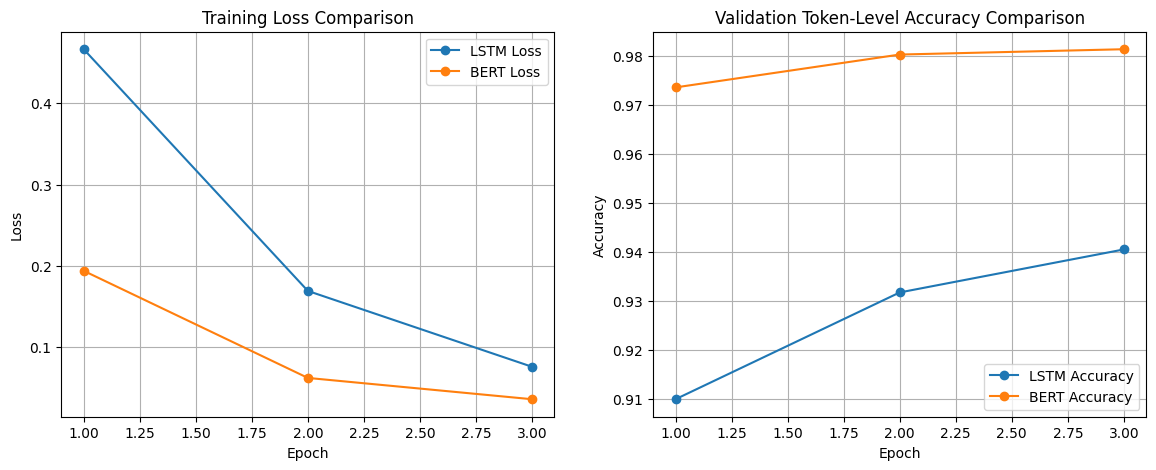

In [42]:
# ===============================
# Final Comparison: LSTM vs BERT
# ===============================

from tqdm import tqdm
from seqeval.metrics import classification_report, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import numpy as np
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def evaluate_model(model, loader, model_name="Model", model_type="lstm"):
    """
    model_type:
      - "lstm": expects forward(ids=..., attention_mask=...) and returns logits [B, C, T]
      - "bert": expects forward(input_ids=..., attention_mask=...) and returns logits [B, C, T]
    """
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        loop = tqdm(loader, desc=f"Evaluating {model_name}")
        for batch in loop:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            if model_type == "bert":
                logits = model(input_ids=input_ids, attention_mask=attention_mask)  # [B, C, T]
            else:
                logits = model(ids=input_ids, attention_mask=attention_mask)  # [B, C, T]

            predictions = torch.argmax(logits, dim=1)  # -> [B, T]

            for i in range(labels.size(0)):
                pred_seq, label_seq = [], []
                for pred_id, label_id in zip(predictions[i], labels[i]):
                    if label_id.item() != -100:
                        pred_seq.append(id2tag[pred_id.item()])
                        label_seq.append(id2tag[label_id.item()])
                all_preds.append(pred_seq)
                all_labels.append(label_seq)

    # Token-level accuracy (on valid positions only)
    correct, total = 0, 0
    for preds, golds in zip(all_preds, all_labels):
        for p, g in zip(preds, golds):
            correct += int(p == g)
            total += 1
    token_acc = correct / total if total > 0 else 0.0

    # Entity-level metrics (seqeval)
    f1 = f1_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)

    print(f"\n=== {model_name} Entity-Level Evaluation ===")
    print(classification_report(all_labels, all_preds))
    print(f"Token-level accuracy: {token_acc:.4f}")
    print(f"Micro F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")

    return all_labels, all_preds, token_acc, f1

# ----------------------
# Evaluating the LSTM model
# ----------------------
lstm_labels, lstm_preds, lstm_token_acc, lstm_f1 = evaluate_model(
    model, test_loader, model_name="LSTMTagger", model_type="lstm"
)

# ----------------------
# Evaluating the BERT model
# ----------------------
bert_labels, bert_preds, bert_token_acc, bert_f1 = evaluate_model(
    bert_model, test_loader, model_name="BERTTagger", model_type="bert"
)

# ----------------------
# Plot comparison: Training Loss & Validation Accuracy
# ----------------------
epochs_lstm = np.arange(1, len(train_losses_lstm) + 1)
epochs_bert = np.arange(1, len(train_losses_bert) + 1)

plt.figure(figsize=(14, 5))

# Training Loss
plt.subplot(1, 2, 1)
plt.plot(epochs_lstm, train_losses_lstm, marker='o', label='LSTM Loss')
plt.plot(epochs_bert, train_losses_bert, marker='o', label='BERT Loss')
plt.title("Training Loss Comparison")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

# Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_lstm, val_accuracies_lstm, marker='o', label='LSTM Accuracy')
plt.plot(epochs_bert, val_accuracies_bert, marker='o', label='BERT Accuracy')
plt.title("Validation Token-Level Accuracy Comparison")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()

plt.show()


## Final comparison (results)

We compare the two NER systems on the same test set using both token-level and entity-level metrics.

### Quantitative results (test set)
- **BiLSTM baseline**
  - Token-level accuracy: **around 0.92**
  - Entity-level micro **F1 around 0.61** (precision in the high 0.5s, recall in the mid 0.6s)
  - Best class: **LOC (F1 around 0.75)**, while **MISC (F1 around the low 0.5s)** remains the most difficult category.

- **Fine-tuned BERT**
  - Token-level accuracy: **around 0.97**
  - Entity-level micro **F1 in the high 0.8s** (precision in the mid 0.8s, recall around ~0.9)
  - Strong improvements across all entity types, with particularly high performance on **PER (F1 around the low-to-mid 0.9s)** and **LOC (F1 around ~0.9)**.
  - **MISC** remains the hardest class, but reaches **solid performance (F1 in the high 0.7s)** and improves substantially compared to BiLSTM.

Overall, BERT improves entity-level micro F1 by **roughly +0.25 to +0.30**, confirming the advantage of fine-tuning a pre-trained contextual encoder for NER.

### Training dynamics (plots)
The training curves support this outcome:
- BERT starts with a lower loss and reaches a low-loss regime quickly, reflecting the benefit of pre-trained representations.
- Validation token-level accuracy for BERT is consistently higher across epochs (roughly **0.97–0.98**), while the BiLSTM baseline improves more gradually and tends to plateau in the **low-to-mid 0.9s**.

### Interpretation
The gap between token-level accuracy and entity-level F1 is expected in NER:
entity-level metrics are stricter because a single boundary or type error can invalidate an entire entity span. BERT’s contextual embeddings reduce boundary/type errors more effectively than the BiLSTM baseline, especially for ambiguous categories such as **ORG** and heterogeneous **MISC** entities.


## **Error analysis and possible improvements**

Across both models, the most challenging categories are **ORG** and especially **MISC**. This matches what we see in the test reports: ORG often trades off precision/recall depending on context, while MISC is consistently harder because it groups many heterogeneous entity types.

**Typical error patterns** (as suggested by the per-class scores):
- **Boundary errors**: entities are detected but with imperfect span boundaries (e.g., missing the first/last token), which lowers entity-level F1 even when token accuracy is high.
- **Type confusions**: the model predicts a plausible entity but with the wrong type (commonly **ORG ↔ PER** or ORG ↔ MISC), especially when names can refer to people, institutions, teams, or products depending on context.
- **Fragmented entities**: long entities may be split into multiple smaller spans due to inconsistent IOB transitions.
**Practical improvements** (high value / low risk):
- **Select the best checkpoint on validation** (early stopping or “best epoch”), rather than always using the final epoch.
- **Tune optimization**: for BERT, add or adjust **weight decay**, and optionally use a simple learning-rate schedule (warmup + linear decay) to stabilize the final epochs.
- **Structured decoding**: add a **CRF layer** on top of token logits to enforce more consistent tag transitions and reduce boundary/fragmentation errors (often most helpful for ORG/MISC).
